In [7]:
import numpy as np
import astropy.cosmology as apcos
from astropy import units as u
from astropy import constants as const

cosmo = apcos.WMAP7 


In [652]:
def interpolate_cen_cen(xi, yi, zi, vxi, vyi, vzi, xf, yf, zf, vxf, vyf, vzf, z_red_i, z_red_f, z_red_interpolate):
    '''
    xi, yi, zi are resecptively all arrays of the initial x,y,z coordinates of each galaxy.
    xf, yf, zf are resecptively all arrays of the final x,y,z coordinates of each galaxy.
    vxi, vyi, vzi are resecptively all arrays of the initial velocity in the x,y,z directions, for each galaxy.
    vxf, vyf, vzf are resecptively all arrays of the final velocity in the x,y,z directions, for each galaxy.
    z_red_i, z_red_f are respectively the initial and final redshifts of the galaxies.
    z_red_interpolate is an array of the redshifts for interpolation, and should be between z_red_i and z_red_f.
    
    All galaxys should have the same initial and final times, and will be interpolated at the same locations.
    
    Note:  Units need to be Mpc/h for distances, and km/s for vecloties'''
    
    
    # Unit conversion:
    #   x/y/zgal   : comoving position in Mpc/h
    #   vx/vy/vzgal: peculiar velocity in km/sec
    #   
    #   Need to convert from peculiar velocities in km/sec
    #   to comoving velocities in (Mpc/h)/Gyr. Will then fit
    #   cubic function to x(t) in comoving coordinates.
    
    
    
    time_interp = cosmo.age(z_red_interpolate)
    ti, tf = cosmo.age([z_red_i, z_red_f])
        
    tscaled = (time_interp - ti) / (tf - ti)
  
    
    # Speed is initially provided as km/s.
    unit_scale = ((tf-ti).to(u.s) * u.km / u.s).to(u.Mpc).value  
    
    #Scale the units - velocities are now comoving.    
    xinit = np.array([xi, yi, zi]).T * cosmo.h
    xfin  = np.array([xf, yf, zf]).T * cosmo.h
    vinit = np.array([vxi, vyi, vzi]).T * unit_scale / cosmo.scale_factor(z_red_i)
    vfin  = np.array([vxf, vyf, vzf]).T * unit_scale / cosmo.scale_factor(z_red_f)

    
    # Rescale t so that t1 = 0 and t2 = 1, then
    # A = x(t1)
    # B = v(t1)
    # C = -2*v(t1) - 3*x(t1) - v(t2) + 3*x(t2)
    # D = v(t1) + v(t2) + 2*(x(t1)-x(t2))
    
    # x(t) = A + B*t + C*t**2 + D*t**3
    # v(t) = B + 2*C*t + 3*D*t**2  
    
     
    A = xinit
    B = vinit
    C = -2*vinit - 3*xinit - vfin + 3*xfin
    D = vinit + vfin + 2*(xinit-xfin)

    
    pos_interp = np.add(A, np.tensordot(tscaled,B,axes=0) + 
                        np.tensordot(np.power(tscaled,2),C,axes=0) + np.tensordot(np.power(tscaled,3),D,axes=0))
    
    vel_interp = np.add(B, 2*np.tensordot(tscaled,C,axes=0) + 
                        3*np.tensordot(np.power(tscaled,2),D,axes=0))
    
    
    #rescale and return times, position, and velocity.     
    return time_interp.value, pos_interp/cosmo.h, (vel_interp.T * cosmo.scale_factor(z_red_interpolate)).T/ unit_scale
        

In [9]:
def time_spaced_interpolation_cen_cen(xi, yi, zi, vxi, vyi, vzi, xf, yf, zf, vxf, vyf, vzf, z_red_i, z_red_f, 
                                      samples=50, return_redshifts=False):
    '''
    xi, yi, zi are resecptively all arrays of the initial x,y,z coordinates of each galaxy.
    xf, yf, zf are resecptively all arrays of the final x,y,z coordinates of each galaxy.
    vxi, vyi, vzi are resecptively all arrays of the initial velocity in the x,y,z directions, for each galaxy.
    vxf, vyf, vzf are resecptively all arrays of the final velocity in the x,y,z directions, for each galaxy.
    z_red_i, z_red_f are respectively the initial and final redshifts of the galaxies.
    
    samples is the number of samples the code uses between the initial and final redshidfts, spread evenly in time.
    return_redshifts causes the redshifts of the samples taken to be returned.
    
    All galaxys should have the same initial and final times, and will be interpolated at the same locations.
    

    
    Note:  Units need to be Mpc/h for distances, and km/s for vecloties
    '''
    ti, tf = cosmo.age([z_red_i, z_red_f])
    ages = np.linspace(ti, tf, samples, endpoint=True)
    redshifts = np.zeros(samples)
    
    #Must be a better way to do this?
    for i, age in enumerate(ages):
        redshifts[i] = apcos.z_at_value(cosmo.age, age)
    
    times, pos, vel = interpolate_cen_cen(xi, yi, zi, vxi, vyi, vzi, xf, yf, zf, 
                                          vxf, vyf, vzf, z_red_i, z_red_f, redshifts)
    
    if return_redshifts:
        return times, pos, vel, redshifts
    else:
        return times, pos, vel
    



In [143]:
def interpolate_sat_sat(sat_xi, sat_yi, sat_zi, sat_vxi, sat_vyi, sat_vzi, 
                        sat_xf, sat_yf, sat_zf, sat_vxf, sat_vyf, sat_vzf, 
                        cen_xi, cen_yi, cen_zi, cen_vxi, cen_vyi, cen_vzi, 
                        cen_xf, cen_yf, cen_zf, cen_vxf, cen_vyf, cen_vzf, 
                        z_red_i, z_red_f, z_red_interpolate):
    '''
    Important note:  There will be an issue in the case that one/both of the positions is at the central galaxy,
    within the avaliable precision.
    '''
    
    TOLERACNE = 1e-20
        
    # Interpolate central galazy
    times, cen_pos, cen_vel = interpolate_cen_cen(cen_xi, cen_yi, cen_zi, cen_vxi, cen_vyi, cen_vzi,
                                                  cen_xf, cen_yf, cen_zf, cen_vxf, cen_vyf, cen_vzf, 
                                                  z_red_i, z_red_f, z_red_interpolate)
    
    # Convert units, and make comoving
    time_interp = cosmo.age(z_red_interpolate)
    ti, tf = cosmo.age([z_red_i, z_red_f])
        
    tscaled = (time_interp - ti) / (tf - ti)
    
    
    # Speed is initially provided as km/s.
    unit_scale = ((tf-ti).to(u.s) * u.km / u.s).to(u.Mpc).value  
    
    #Find relative to central galaxy, and scale the units - velocities are now comoving.    
    xinit = np.array([sat_xi - cen_xi, sat_yi - cen_yi, sat_zi - cen_zi]).T * cosmo.h
    xfin  = np.array([sat_xf - cen_xf, sat_yf - cen_yf, sat_zf - cen_zf]).T * cosmo.h
    vinit = np.array([sat_vxi - cen_vxi, sat_vyi - cen_vyi, sat_vzi - cen_vzi]).T * unit_scale / cosmo.scale_factor(z_red_i)
    vfin  = np.array([sat_vxf - cen_vxf, sat_vyf - cen_vyf, sat_vzf - cen_vzf]).T * unit_scale / cosmo.scale_factor(z_red_f)
    
    # Find initial and final radii
    rinit = np.linalg.norm(xinit, axis=1, keepdims=True)
    rfin  = np.linalg.norm(xfin,  axis=1, keepdims=True)
   
    
    # Find coordinate system so that initial and final postions of the satalite galaxy are
    # in the XY plane, with centeral galaxy at origin.
    x_axis_vector = xinit / rinit
    z_axis_vector = np.cross(x_axis_vector, xfin/rfin)
    
    #For when the two position vectors are almost parrallel:
    where_parrallel = np.where(np.linalg.norm(z_axis_vector, axis=1)<TOLERANCE)[0]
    
    # In this case, produce a new vector known not to be parrallel to them, and use that
    # to produce the z_axis_vector
    skewed_vec = x_axis_vector[i] + [0.6,-0.3,0.4]
    z_axis_vector[where_parrallel] = np.cross(x_axis_vector[where_parrallel], skewed_vec/numpy.linalg.norm(skewed_vec, axis=1))
    
    # Get y axis vector
    y_axis_vector = np.cross(x_axis_vector, z_axis_vector)
    
    #get new x and y coordinates of position 2
    x_coords = np.dot(x_axis_vector,xfin.T)
    y_coords = np.dot(x_axis_vector,xfin.T)
    
    #get angles between them at the relevent times
    thetas = np.arctan2(y,x)
    
    
            
    

redfhits:  [ 0.279802    0.28059608  0.28139098  0.2821867   0.28298324  0.28378061
  0.2845788   0.28537781  0.28617765  0.28697832  0.28777982  0.28858215
  0.28938532  0.29018932  0.29099415  0.29179983  0.29260635  0.2934137
  0.2942219   0.29503095  0.29584084  0.29665158  0.29746316  0.2982756
  0.29908889  0.29990303  0.30071803  0.30153389  0.30235061  0.30316819
  0.30398662  0.30480593  0.3056261   0.30644713  0.30726903  0.30809181
  0.30891546  0.30973998  0.31056538  0.31139165  0.3122188   0.31304683
  0.31387575  0.31470555  0.31553623  0.31636781  0.31720027  0.31803361
  0.31886786  0.319703  ]

age of universe (Gyr):  [ 10.52465867  10.51709933  10.50953994  10.50198056  10.49442123
  10.48686184  10.47930246  10.47174313  10.46418381  10.4566244
  10.44906503  10.4415057   10.43394628  10.42638696  10.41882763
  10.41126826  10.40370886  10.39614954  10.38859015  10.38103077
  10.37347141  10.36591203  10.35835271  10.35079336  10.34323398
  10.33567462  10.32811526 

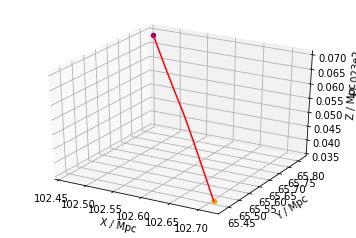

In [191]:
#Note: My personal testing

import matplotlib.pyplot as pyplot

init, fin = [102.71537, 65.430832, 102.336548], [102.46154, 65.814896, 102.368958]
initv, finv = [756.42688, -1104.071655, -121.157196], [716.478271, -1081.993042, -89.589539]


times, pos, vel, redshifts = time_spaced_interpolation_cen_cen(init[0],init[1],init[2],initv[0],initv[1],initv[2], 
                                                               fin[0],fin[1],fin[2],finv[0],finv[1],finv[2], 
                                                               0.279802, 0.319703, return_redshifts=True)
print "redfhits: ", redshifts
print ""
print "age of universe (Gyr): ", times

#pyplot.figure()
#pyplot.scatter(pos[:,0], pos[:,1], c="red")
#pyplot.scatter(pos[0,0], pos[0,1], c="orange")
#pyplot.scatter(pos[-1,0], pos[-1,1], c="purple")
#pyplot.show()

from mpl_toolkits.mplot3d import Axes3D

fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(pos[:,0], pos[:,1], pos[:,2], c="red")
ax.scatter(pos[0,0], pos[0,1], pos[0,2], c="orange")
ax.scatter(pos[-1,0], pos[-1,1], pos[-1,2], c="purple")

ax.set_xlabel('X / Mpc')
ax.set_ylabel('Y / Mpc')
ax.set_zlabel('Z / Mpc')

pyplot.show()


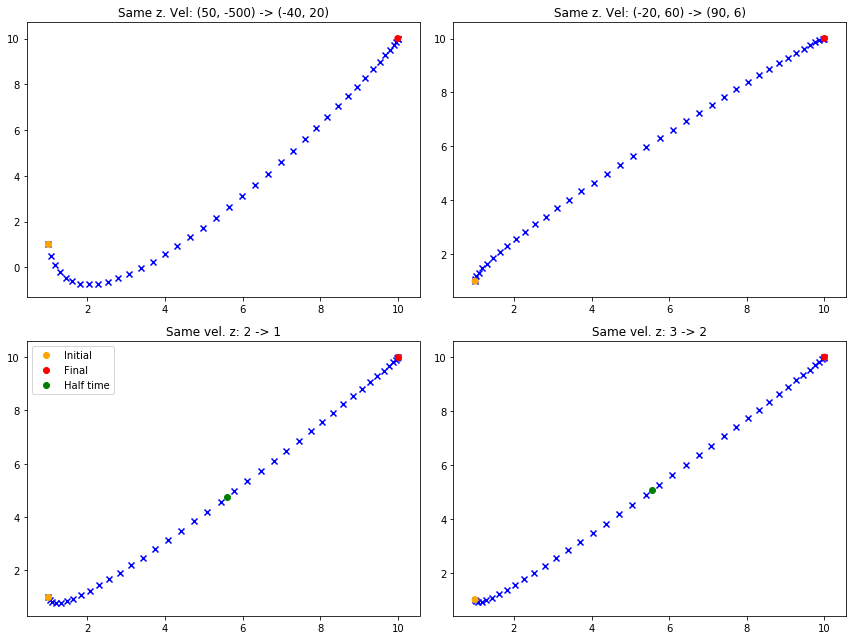

In [655]:
import matplotlib.pyplot as pyplot
smpls = 40


init, fin = [1,1,0], [10,10,0]
initv, finv = [50, -500, 0], [-40, 20, 0]

times, pos, vel = time_spaced_interpolation_cen_cen(init[0],init[1],init[2],initv[0],initv[1],initv[2],
                    fin[0],fin[1],fin[2],finv[0],finv[1],finv[2],5,1,samples=smpls) 

#print pos

#print vel

fig = pyplot.figure(figsize=(12,9))

pyplot.subplot(221)
pyplot.title("Same z. Vel: (50, -500) -> (-40, 20)")
pyplot.scatter(pos[:,0], pos[:,1], c="blue", marker="x")
pyplot.scatter([init[0], fin[0]], [init[1], fin[1]], c=["orange", "red"])
#pyplot.xlim([-2, 12])
#pyplot.ylim([-12,12])




init, fin = [1,1,0], [10,10,0]
initv, finv = [-20, 60, 0], [90, 6,0]

times, pos, vel = time_spaced_interpolation_cen_cen(init[0],init[1],init[2],initv[0],initv[1],initv[2],
                    fin[0],fin[1],fin[2],finv[0],finv[1],finv[2],5,1,samples=smpls) 

#print pos

#print vel


pyplot.subplot(222)
pyplot.title("Same z. Vel: (-20, 60) -> (90, 6)")
pyplot.scatter(pos[:,0], pos[:,1], c="blue", marker="x")
pyplot.scatter([init[0], fin[0]], [init[1], fin[1]], c=["orange", "red"])
#pyplot.xlim([-2, 12])
#pyplot.ylim([-12,12])




init, fin = [1,1,0], [10,10,0]
initv, finv = [50, -500, 0], [-40, 20, 0]

times, pos, vel = time_spaced_interpolation_cen_cen(init[0],init[1],init[2],initv[0],initv[1],initv[2],
                    fin[0],fin[1],fin[2],finv[0],finv[1],finv[2],2,1,samples=smpls) 

midtime_z =  apcos.z_at_value(cosmo.age, cosmo.age(2) + (cosmo.age(1) - cosmo.age(2))/2)

st, sp, sv = interpolate_cen_cen(init[0],init[1],init[2],initv[0],initv[1],initv[2],
                    fin[0],fin[1],fin[2],finv[0],finv[1],finv[2],2,1,midtime_z)

pyplot.subplot(223)
pyplot.title("Same vel. z: 2 -> 1")
pyplot.scatter(pos[:,0], pos[:,1], c="blue", marker="x")
pyplot.scatter(init[0], init[1], c="orange", label="Initial")
pyplot.scatter(fin[0], fin[1], c="red", label="Final")
pyplot.scatter(sp[0], sp[1], c="green", label="Half time")
#pyplot.xlim([-2, 12])
#pyplot.ylim([-12,12])

pyplot.legend()               
               
init, fin = [1,1,0], [10,10,0]
initv, finv = [50, -500, 0], [-40, 20, 0]

times, pos, vel = time_spaced_interpolation_cen_cen(init[0],init[1],init[2],initv[0],initv[1],initv[2],
                    fin[0],fin[1],fin[2],finv[0],finv[1],finv[2],3,2,samples=smpls) #,np.linspace(2,3,30))

midtime_z =  apcos.z_at_value(cosmo.age, cosmo.age(3) + (cosmo.age(2) - cosmo.age(3))/2)

st, sp, sv = interpolate_cen_cen(init[0],init[1],init[2],initv[0],initv[1],initv[2],
                    fin[0],fin[1],fin[2],finv[0],finv[1],finv[2],3,2,midtime_z)



pyplot.subplot(224)
pyplot.title("Same vel. z: 3 -> 2")
pyplot.scatter(pos[:,0], pos[:,1], c="blue", marker="x")
pyplot.scatter([init[0], fin[0]], [init[1], fin[1]], c=["orange", "red"])
pyplot.scatter(sp[0], sp[1], c="green", label="Half time")
#pyplot.xlim([-2, 12])
#pyplot.ylim([-12,12])

fig.tight_layout()

pyplot.show()

#pyplot.figure()
#pyplot.plot(times, np.linalg.norm(vel,axis=1))
#pyplot.show()


[ 15.7487552   10.70936817   0.        ]
[ 15.74875717  10.70937012   0.        ]


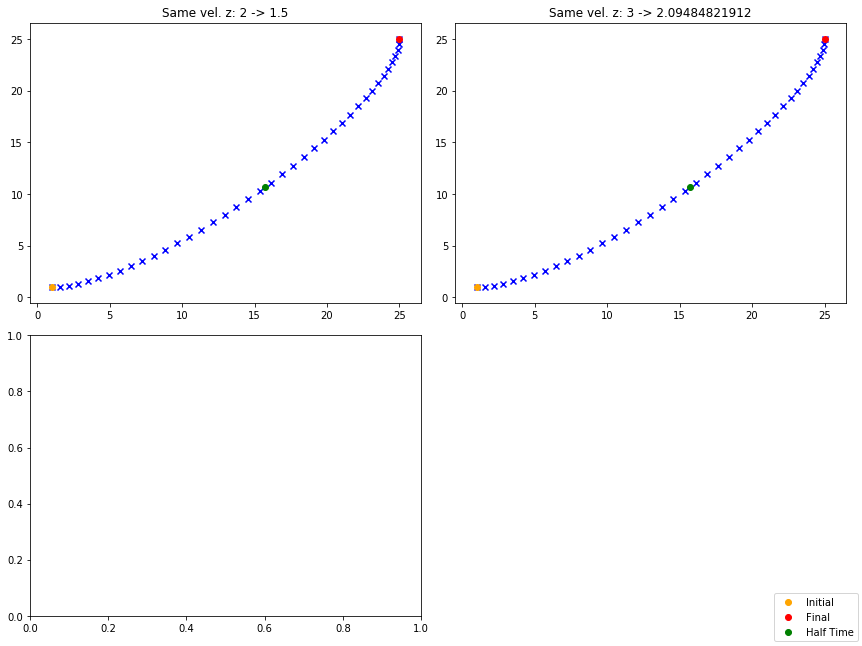

In [93]:
fig = pyplot.figure(figsize=(12,9))

zi1 = 2
zf1 = 1.5
init1, fin1 = np.array([1,1,0]), np.array([25,25,0])
initv1, finv1 = np.array([5000, 0, 0]), np.array([0, 5000, 0])

times1, pos1, vel1 = time_spaced_interpolation_cen_cen(init1[0],init1[1],init1[2],initv1[0],initv1[1],initv1[2],
                                                       fin1[0],fin1[1],fin1[2],finv1[0],finv1[1],finv1[2],zi1,zf1,
                                                       samples=smpls) 

midtime_z2 =  apcos.z_at_value(cosmo.age, cosmo.age(zi1) + (cosmo.age(zf1) - cosmo.age(zi1))/2)

st1, sp1, sv1 = interpolate_cen_cen(init1[0],init1[1],init1[2],initv1[0],initv1[1],initv1[2],
                                 fin1[0],fin1[1],fin1[2],finv1[0],finv1[1],finv1[2],zi1,zf1, midtime_z2)

pyplot.subplot(221)
pyplot.title("Same vel. z: " + str(zi1) + " -> " + str(zf1))
pyplot.scatter(pos1[:,0], pos1[:,1], c="blue", marker="x")
s1 = pyplot.scatter(init1[0], init1[1], c="orange", label="Initial")
s2 = pyplot.scatter(fin1[0], fin1[1], c="red", label="Final")
s3 = pyplot.scatter(sp1[0], sp1[1], c="green", label="Half time")
#pyplot.xlim([-2, 12])
#pyplot.ylim([-12,12])
        
               



zi2 = 3
zf2 = apcos.z_at_value(cosmo.age, cosmo.age(zi2) + (cosmo.age(zf1) - cosmo.age(zi1)))
init2, fin2 = init1, fin1
initv2  = initv1 * cosmo.scale_factor(zi2) /cosmo.scale_factor(zi1) 
finv2   = finv1  * cosmo.scale_factor(zf2) /cosmo.scale_factor(zf1)


times2, pos2, vel2 = time_spaced_interpolation_cen_cen(init2[0],init2[1],init2[2],initv2[0],initv2[1],initv2[2],
                                                       fin2[0],fin2[1],fin2[2],finv2[0],finv2[1],finv2[2],zi2,zf2,
                                                       samples=smpls) 

midtime_z2 =  apcos.z_at_value(cosmo.age, cosmo.age(zi2) + (cosmo.age(zf2) - cosmo.age(zi2))/2)

st2, sp2, sv2 = interpolate_cen_cen(init2[0],init2[1],init2[2],initv2[0],initv2[1],initv2[2],
                                 fin2[0],fin2[1],fin2[2],finv2[0],finv2[1],finv2[2],zi2,zf2, midtime_z2)

pyplot.subplot(222)
pyplot.title("Same vel. z: " + str(zi2) + " -> " + str(zf2))
pyplot.scatter(pos2[:,0], pos2[:,1], c="blue", marker="x")
s1 = pyplot.scatter(init2[0], init2[1], c="orange", label="Initial")
s2 = pyplot.scatter(fin2[0], fin2[1], c="red", label="Final")
s3 = pyplot.scatter(sp2[0], sp2[1], c="green", label="Half time")
#pyplot.xlim([-2, 12])
#pyplot.ylim([-12,12])


pyplot.subplot(223)







fig.legend((s1,s2,s3),("Initial","Final","Half Time"), loc=4)


fig.tight_layout()

print sp1
print sp2

pyplot.show()

In [640]:
print np.array([0,1,2,3]).T

[0 1 2 3]
